In [ ]:
"""
José Javier Calvo Moratilla
MUIARFID 2021-2022
VPC
Car Model Classification
.
Dataset: 
"""

#################################################################
# Imports
#################################################################
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
#from keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm
from sklearn.model_selection import train_test_split


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#################################################################
# Parameters
#################################################################
batch_size = 32
num_classes = 20
epochs_notrain = 50
epochs = 250

input_folder = "drive/MyDrive/MUIARFID/VPC/CarModels/"
data_dat = "drive/MyDrive/MUIARFID/VPC/CarModels/data/"

In [ ]:
#################################################################
# Prepare model model saving directory.
#################################################################
save_dir = os.path.join(input_folder, 'saved_models')
name_model = "JJCM_CarModel_best_model.hdf5"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, name_model)

plot_dir = os.path.join(input_folder, 'plots')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

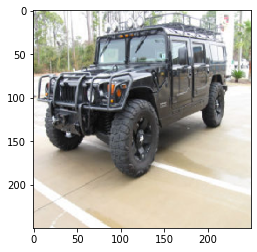

(791, 250, 250, 3)
(791, 20)
-----------------------
(392, 250, 250, 3)
(392, 20)
-----------------------
(392, 250, 250, 3)
(392, 20)


In [ ]:
#################################################################
# Load data and preprocess
#################################################################

### LOAD AND TRANSFORM

## Download: ONLY ONCE!
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')
#####


# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')



## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()



#x_train /= 255
#x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_test, x_dev, y_test, y_dev = train_test_split(x_test, y_test, test_size=0.5, random_state=None, shuffle=True)

# Stats
print(x_train.shape)
print(y_train.shape)
print('-----------------------')
print(x_dev.shape)
print(y_dev.shape)
print('-----------------------')
print(x_test.shape)
print(y_test.shape)

In [ ]:
#################################################################
# Build Data Augmentation
#################################################################
'''datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True
  )
'''
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.5,
        height_shift_range=0.5,
        shear_range=0.3,
        zoom_range=[1.0,1.2],
        horizontal_flip=True,
        fill_mode='nearest'  
  )


def multiple_data_generator(generator, X,Y,bs):
    genX = generator.flow(X, Y,batch_size=bs)
    while True:
      [Xi,Yi] = genX.next()
      yield [Xi,Xi],Yi

In [ ]:
#################################################################
# Build ReduceLROnPlateau
#################################################################
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    cooldown=1,
    patience=10, 
    min_lr=5e-4
)

#################################################################
# Check point
#################################################################
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)

#################################################################
# EarlyStop
#################################################################
early_stop = EarlyStopping(patience= 20, restore_best_weights=True, monitor="val_accuracy")

In [ ]:

#############################
###      BILINEAR        ####
#############################

def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,7*7)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt, dim=1)								              # Apply l2 normalization
  return z_l2


In [ ]:
#################################################################
# Build the model
#################################################################
model_pretained_1 = VGG16(weights='imagenet', include_top=False)
model_pretained_2 = VGG16(weights='imagenet', include_top=False)

for layer in range(len(model_pretained_1.layers)):
  model_pretained_1.layers[layer].trainable = False
  model_pretained_2.layers[layer].trainable = False
  model_pretained_1.layers[layer]._name += '_1'
  model_pretained_2.layers[layer]._name += '_2'

conv1 = model_pretained_1.layers[-1].output
conv2 = model_pretained_2.layers[-1].output

x = Lambda(outer_product, name='outer_product')([conv1, conv2])

output = Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=[model_pretained_1.input, model_pretained_2.input], outputs=output)

opt_1 = SGD(lr=0.1, decay=1e-6)
opt_2 = Adam(learning_rate=1e-3, decay=1e-6)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt_2,
    metrics=['accuracy']
)



Instructions for updating:
dim is deprecated, use axis instead


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#################################################################
# Training
#################################################################
history=model.fit(
    multiple_data_generator(datagen, x_train, y_train,batch_size),
    steps_per_epoch = len(x_train) / batch_size, 
    epochs=epochs_notrain,
    validation_data=([x_dev, x_dev], y_dev),
    callbacks=[reduce_lr],
    verbose=1
)



Epoch 1/50
24/24 [==============================] - 37s 1s/step - loss: 2.9544 - accuracy: 0.1024 - val_loss: 2.7961 - val_accuracy: 0.2934 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - 16s 664ms/step - loss: 2.7234 - accuracy: 0.2933 - val_loss: 2.6019 - val_accuracy: 0.3265 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - 16s 666ms/step - loss: 2.5278 - accuracy: 0.3464 - val_loss: 2.4615 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 4/50
24/24 [==============================] - 16s 656ms/step - loss: 2.3812 - accuracy: 0.4513 - val_loss: 2.3375 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 5/50
24/24 [==============================] - 16s 661ms/step - loss: 2.2496 - accuracy: 0.4627 - val_loss: 2.2439 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 6/50
24/24 [==============================] - 16s 671ms/step - loss: 2.1545 - accuracy: 0.5044 - val_loss: 2.1608 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 7/50
24/24 [==============================] - 16s 666ms/step 

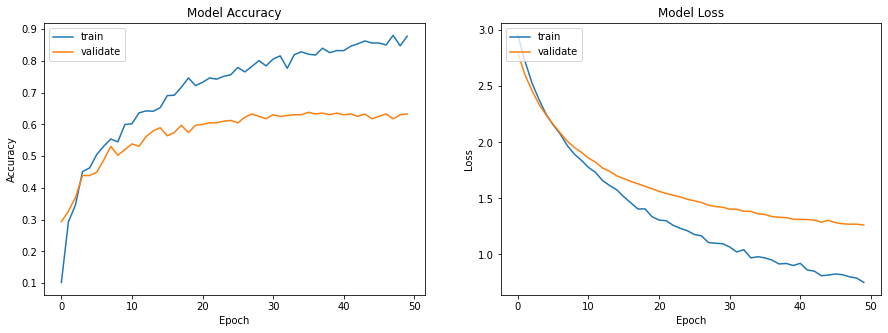

In [ ]:
#################################################################
# Stats Train
#################################################################
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    #plt.savefig(input_folder + '/plots/resnet50v2_gender.png')
    plt.show()

plotmodelhistory(history)

In [ ]:
#Ahora se coge el modelo entrenado, se hace trainable y se vuelve a entrenar

opt_1 = Adam(learning_rate=1e-6, decay=1e-12)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    cooldown=1,
    patience=10, 
    min_lr=5e-8
)

for layer in tqdm(range(len(model_pretained_1.layers))):
  model_pretained_1.layers[layer].trainable = False
  model_pretained_2.layers[layer].trainable = False


model.compile(
    loss='categorical_crossentropy',
    optimizer=opt_2,
    metrics=['accuracy']
)

#################################################################
# Training
#################################################################
history=model.fit(
    multiple_data_generator(datagen, x_train, y_train,batch_size),
    steps_per_epoch = len(x_train) / batch_size, 
    epochs=epochs,
    validation_data=([x_test, x_test], y_test),
    callbacks=[reduce_lr, checkpoint, early_stop],
    verbose=1
)

100%|██████████| 19/19 [00:00<00:00, 5805.90it/s]


Epoch 1/250
25/24 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.8925
Epoch 1: val_loss improved from inf to 1.19896, saving model to drive/MyDrive/MUIARFID/VPC/CarModels/saved_models/JJCM_CarModel_best_model.hdf5
24/24 [==============================] - 19s 737ms/step - loss: 0.7385 - accuracy: 0.8925 - val_loss: 1.1990 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 2/250
25/24 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.8673
Epoch 2: val_loss did not improve from 1.19896
24/24 [==============================] - 16s 677ms/step - loss: 0.7409 - accuracy: 0.8673 - val_loss: 1.2013 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 3/250
25/24 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.8748
Epoch 3: val_loss improved from 1.19896 to 1.19348, saving model to drive/MyDrive/MUIARFID/VPC/CarModels/saved_models/JJCM_CarModel_best_model.hdf5
24/24 [==============================] - 18s 723ms/step - loss: 0.7291 - accuracy: 0.8

392/392 [==============================] - 11s 22ms/step - loss: 1.0597 - accuracy: 0.6658
Test loss: 1.0597293376922607
Test accuracy: 0.6658163070678711


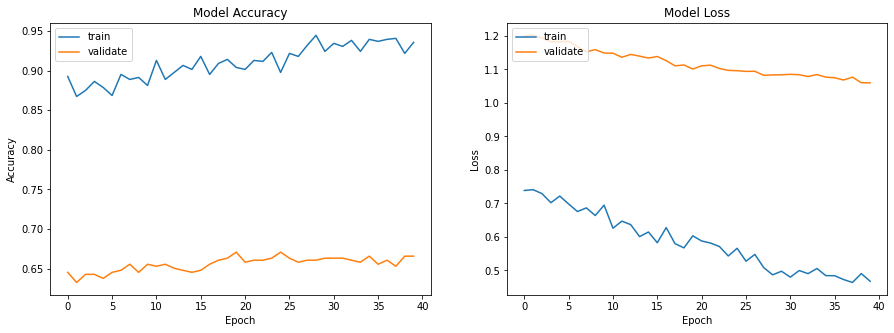

In [ ]:
#################################################################
# Load the best model obtained
#################################################################
best_model = Model(inputs=[model_pretained_1.input, model_pretained_2.input], outputs=output)

best_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt_2,
    metrics=['accuracy']
)

best_model.load_weights(filepath)
scores = best_model.evaluate([x_test, x_test], y_test, steps = len(x_test), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])  
plotmodelhistory(history)